# Assignment 5: Large Language Models (48 marks total)
### Due: November 28 at 11:59pm

### Name: Hiu Sum Yuen

The goal of the assignment is to practice using BERT. For this assignment, we will define our own BERT model and use manual training and testing loops.

## Part 1: BERT

### Step 0: Import Libraries

In [1]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.optim import Adam
from transformers import BertModel, BertTokenizer
import evaluate
import numpy as np
import torch
from tqdm import tqdm

/Users/ben/Desktop/school/courses/5thyear/ensf519/Assignment5/ENSF519_machineLearning_Assignment5/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For more information on BertModel and BertTokenizer, check out https://huggingface.co/docs/transformers/en/model_doc/bert

### Part 1: Import Data (3 marks)

We will be using news stories from the BBC for this assignment. The csv file is included on D2L.

In [5]:
# TO DO: Import the data and print the first few rows (1 mark)
df = pd.read_csv('bbc-text.csv')

# Print the first 5 rows
print(df.head())
print(f"\nDataset shape: {df.shape}")

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...

Dataset shape: (2225, 2)


This dataset has five different categories for the different news articles. We can plot the data by category to see how many articles belong to each category.


Articles per category:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


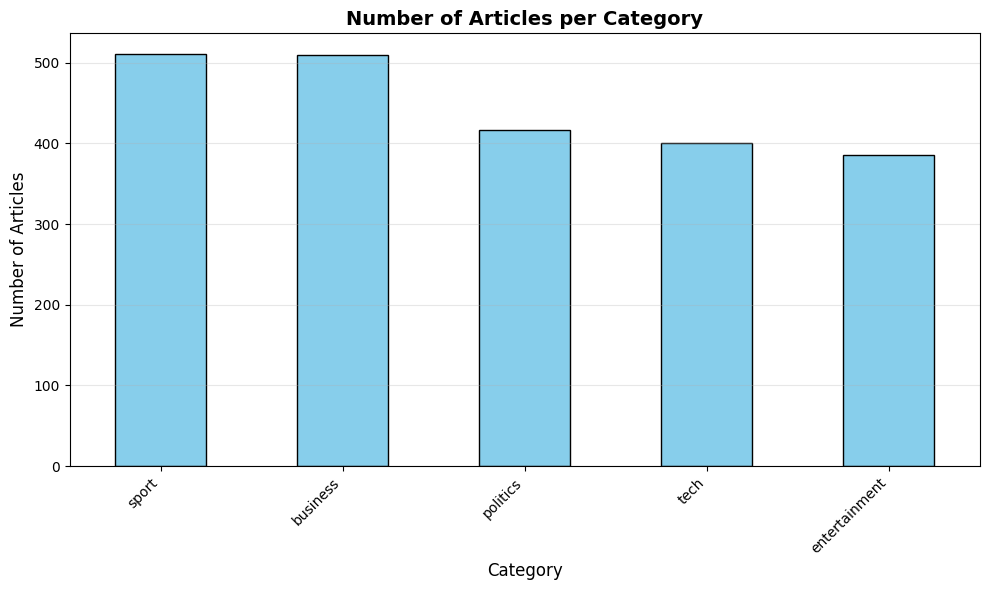

In [12]:
# TO DO: Bar plot to display number of articles per category (1 mark)
import matplotlib.pyplot as plt

# Count articles per category
countCategory = df['category'].value_counts()
print("\nArticles per category:")
print(countCategory)

# Create bar plot
plt.figure(figsize=(10, 6))
countCategory.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Articles per Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

We need to split the data into training, validation and testing datasets. This code has been provided.

In [13]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


/Users/ben/Desktop/school/courses/5thyear/ensf519/Assignment5/ENSF519_machineLearning_Assignment5/venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


We can create a labels dictionary for the different categories (the key is the category name, the value is a number (0-4)).

In [14]:
# TO DO: Create labels dictionary (1 mark)

# Map to numbers 0-4
labels = {category: idx for idx, category in enumerate(df['category'].unique())}

# Print the labels dictionary
print("Labels dictionary:")
print(labels)

Labels dictionary:
{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4}


### Step 2: Model Definition (7 marks)

For our BERT model, we have two different options: uncased and cased. Uncased converts everything into lower case, while cased leaves the upper case letters as is. Select one of these options for this assignment (you will justify your choice in the questions).

We need to define the tokenizer for the data. The tokenizer we will be using is the `BertTokenizer`.

In [15]:
# TO DO: Define the tokenizer (1 mark)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We also need to define a custom Dataset class. For BERT, the input is limited to 512, so we can truncate to this length and pad anything shorter than this. Look at the tokenizer function that we are using to figure out what inputs we need to accomplish this. What return type should the tokenizer function have?

In [16]:
class Dataset(torch.utils.data.Dataset): 

    def __init__(self, df):
        # TO DO: Complete self.labels and self.text (2 marks)
        # self.labels = list of labels (numerical value)
        # self.texts = list with tokenized text data
        
        # Convert category names to numerical labels using the labels dictionary
        self.labels = [labels[label] for label in df['category']]
        
        # Tokenize all text data with padding and truncation to max length 512
        self.texts = [tokenizer(text, padding='max_length', max_length=512, truncation=True, return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

The last element we need to define is the BERT classifier. For this assignment, we will be using `BertModel`. The output of the BERT model is an embedding vector with length 768. We will need a one-layer neural network for the classification portion (you can define a `ReLU()` step after the linear layer). You can use a dropout layer before the linear layer to help with generalization.

In [17]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        # TO DO: Define the bert, dropout, linear and ReLU layers (2 marks)

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        # TO DO: Complete the steps for the bert model (2 marks)
        # Look at the data and the bert model documentation for hints on how to complete this

        # Apply Layers
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_output = self.relu(linear_output)
        
        return final_output
    
model = BertClassifier()

### Step 3: Model Training and Validation (20 marks)

We can use our custom dataset class to process the data before loading the data into dataloaders.

In [18]:
# TO DO: Convert training, validation and testing data into dataloaders - use batch_size = 2 (3 marks)

# Create Dataset instances for train, validation, and test sets
train_dataset = Dataset(df_train)
val_dataset = Dataset(df_val)
test_dataset = Dataset(df_test)

# Create DataLoaders with batch_size = 2
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2)

# Print dataloader information
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 890
Number of validation batches: 111
Number of test batches: 112


For this case, we can use `CrossEntropyLoss()` and `Adam()` for our optimization.

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 1e-5)

We can use the accuracy metrics from the `evaluate` library for training and evaluation. We will use accuracy and f1 score for this case.

In [22]:
# TO DO: Load the metrics for training and evaluation (1 mark)
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

The next step is to define the training and evaluation loops. You may need to look at the data to determine the model inputs. You can use `tqdm` to create a progress bar to see the status of your code.

In [23]:
# TO DO: Training loop (6 marks)
def train(model, train_dataloader, optimizer, criterion, device):
    """
    Training loop for one epoch
    """
    model.train()
    total_loss = 0
    
    # Progress bar
    progress_bar = tqdm(train_dataloader, desc="Training")
    
    for batch_texts, batch_labels in progress_bar:
        # Get input_ids and attention_mask from tokenized texts
        input_ids = batch_texts['input_ids'].squeeze(1).to(device)
        attention_mask = batch_texts['attention_mask'].squeeze(1).to(device)
        labels = torch.tensor(batch_labels).to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


In [24]:
# TO DO: Evaluation loop (5 marks)
def evaluate(model, dataloader, device):
    """
    Evaluation loop - computes predictions and returns metrics
    """
    model.eval()
    all_predictions = []
    all_labels = []
    
    # Progress bar
    progress_bar = tqdm(dataloader, desc="Evaluating")
    
    with torch.no_grad():
        for batch_texts, batch_labels in progress_bar:
            # Get input_ids and attention_mask from tokenized texts
            input_ids = batch_texts['input_ids'].squeeze(1).to(device)
            attention_mask = batch_texts['attention_mask'].squeeze(1).to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            
            # Get predictions
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            
            # Store predictions and labels
            all_predictions.extend(predictions)
            all_labels.extend(batch_labels)
    
    # Add results to metrics
    accuracy_metric.add_batch(predictions=all_predictions, references=all_labels)
    f1_metric.add_batch(predictions=all_predictions, references=all_labels)
    
    # Compute final metrics
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute(average='weighted')
    
    return accuracy, f1

Create a function that can be used to help you print the results for both the accuracy and f1 score.

In [25]:
# TO DO: Printing function (1 mark)
def print_metrics(accuracy, f1, dataset_name=""):
    """
    Print accuracy and F1 score in a formatted way
    
    Args:
        accuracy: Dictionary with accuracy score
        f1: Dictionary with F1 score
        dataset_name: Optional string to specify which dataset (e.g., "Validation", "Test")
    """
    print(f"\n{'='*50}")
    if dataset_name:
        print(f"{dataset_name} Results:")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy['accuracy']:.4f} ({accuracy['accuracy']*100:.2f}%)")
    print(f"F1 Score: {f1['f1']:.4f}")
    print(f"{'='*50}\n")

As stated in class, BERT is a pre-trained model that we can augment with additional data. What happens when we run the testing data on the BERT model without fine-tuning?

In [26]:
# TO DO: Test without fine-tuning and print results (1 mark)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate on test data without fine-tuning
print("Testing model WITHOUT fine-tuning:")
accuracy, f1 = evaluate(model, test_dataloader, device)
print_metrics(accuracy, f1, "Test (Before Fine-tuning)")

Testing model WITHOUT fine-tuning:


Evaluating: 100%|██████████| 112/112 [00:41<00:00,  2.70it/s]



Test (Before Fine-tuning) Results:
Accuracy: 0.1839 (18.39%)
F1 Score: 0.0639



Now we can fine-tune the model by training it with the BBC news data. For this assignment, we will only run one epoch, as it takes a long time to run.

In [29]:
# TO DO: Run one epoch for training and validation data and print results (2 marks)

# Train for one epoch
print("\n" + "="*50)
print("Starting Fine-tuning (1 epoch)")
print("="*50)

train_loss = train(model, train_dataloader, optimizer, criterion, device)
print(f"\nTraining Loss: {train_loss:.4f}")

# Evaluate on validation data
print("\nEvaluating on validation set:")
val_accuracy, val_f1 = evaluate(model, val_dataloader, device)
print_metrics(val_accuracy, val_f1, "Validation (After Fine-tuning)")


Starting Fine-tuning (1 epoch)


Training:   0%|          | 0/890 [00:00<?, ?it/s]/var/folders/hk/2btvw_ms30b3wncwb_4d923r0000gn/T/ipykernel_78350/21021489.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch_labels).to(device)
Training: 100%|██████████| 890/890 [43:21<00:00,  2.92s/it, loss=0.605]   



Training Loss: 0.3452

Evaluating on validation set:


Evaluating: 100%|██████████| 111/111 [00:35<00:00,  3.10it/s]


Validation (After Fine-tuning) Results:
Accuracy: 0.9910 (99.10%)
F1 Score: 0.9909



Now we can test the model again after fine-tuning.

In [30]:
# TO DO: Test the model (1 mark)
print("\nTesting model AFTER fine-tuning:")
test_accuracy, test_f1 = evaluate(model, test_dataloader, device)
print_metrics(test_accuracy, test_f1, "Test (After Fine-tuning)")


Testing model AFTER fine-tuning:


Evaluating: 100%|██████████| 112/112 [00:39<00:00,  2.80it/s]



Test (After Fine-tuning) Results:
Accuracy: 0.9910 (99.10%)
F1 Score: 0.9910



## Part 2: Questions and Process Description

### Questions (12 marks)

1. Which version of BERT did you select? Why?
1. What are the pros and cons of using uncased compared to cased?
1. What potential issues arise when truncating long news headlines or articles?
1. How did the model work without fine-tuning? Why do you think it worked this way?
1. How might a news classifier using a pre-trained model inadvertently encode bias?
1. Why is F1-score sometimes more informative than accuracy on text classification?

*ANSWER HERE*
1. Uncased, it would provide a simpler classification since the model doesn't have to learn between upper and lower case. Also, news articles are not a form of text that rely on case changing to manipulate the meaning of words.
1. Pros are better generalization and less training complexity. Cons are the lacking of information and context provided by Capitalization such as Names.
1. Lost of information, sometimes articles make their summarising thoughts later in the article. Truncating can cause our model to learn from data that is not representative of the truth.
1. The model performed terribly, at 18% accuracy, it's worse than random guessing which would be a 1/5 chance of being correct. The model wasn't trained with context of the data, just a general understanding of language, hence we get something like random guessing.
1. Since we only use english data to learn, specifically from BBC news only, the model learns only from the viewpoint of BBC, hence picking up cultural and political biases.
1. F1 score is a better metric for imbalanced datasets, providing a score metric based on how well the model provides a true positive output in proportion to it's false positive and false negative outputs.

### Process Description (4 marks)
Please describe the process you used to create your code. Cite any websites or generative AI tools used. You can use the following questions as guidance:
1. Where did you source your code?
1. In what order did you complete the steps?
1. If you used generative AI, what prompts did you use? Did you need to modify the code at all? Why or why not?
1. Did you have any challenges? If yes, what were they? If not, what helped you to be successful?

*DESCRIBE YOUR PROCESS HERE - BE SPECIFIC*
1. DeepSeek, ChatGPT
1. Orthodox
1. "HELP what does this do, HELP MEEEE i don't understand", I modified code to get better final scores, going from 70% to 99% accuracy. I was a fiend for optimizing the model.
1. Yes, I only understood BERT and bidirectional transformers theoretically, doing the assignment helped me understand the material practically.

## Part 3: Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challenging, motivating
while working on this assignment.


*ADD YOUR THOUGHTS HERE*

Yes, I liked this assignment more than assignment 4 where we do RNN because for this assignment my model was actually learning, whereas in the last assignment i couldn't figure out why my model was not learning.